# Index

### Table of Contents

Input index here once all sections are finalised!

# Introduction

 * What is the Project
 * Why is it important
 * How will we go about doing it

# Data size and structure

The Data's size and structure 

# Load Dependencies

In [1]:
# Install packages here
# Packages for data processing
import numpy as np
import pandas as pd
import datetime
from sklearn import preprocessing
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import re
from scipy.sparse import csr_matrix
import scipy as sp


# Packages for visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Packages for modeling
from surprise import Reader
from surprise import Dataset
from surprise import KNNWithMeans
from surprise import KNNBasic
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV
from surprise import SVD
from surprise import SVDpp
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering
import heapq

# Packages for model evaluation
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from time import time

# Package to suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Packages for saving models
import pickle

# Data Collection

In [4]:
df_sample_submission = pd.read_csv('resources/sample_submission.csv')
df_movies = pd.read_csv('resources/movies.csv')
df_imdb = pd.read_csv('resources/imdb_data.csv')
df_genome_scores = pd.read_csv('resources/genome_scores.csv')
df_genome_tags = pd.read_csv('resources/genome_tags.csv')
df_train = pd.read_csv('resources/train.csv')
df_test = pd.read_csv('resources/test.csv')
df_tags = pd.read_csv('resources/tags.csv')
df_links = pd.read_csv('resources/links.csv')

In [5]:
df_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [8]:
df_sample_submission.head()

,Id,rating
0,1_2011,1.0
1,1_4144,1.0
2,1_5767,1.0
3,1_6711,1.0
4,1_7318,1.0


In [12]:
df_train.head()

,userId,movieId,rating,timestamp
0,5163,57669,4.0,1518349992
1,106343,5,4.5,1206238739
2,146790,5459,5.0,1076215539
3,106362,32296,2.0,1423042565
4,9041,366,3.0,833375837


In [13]:
df_imdb.head()

,movieId,title_cast,director,runtime,budget,plot_keywords
0,1,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation
1,2,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Jonathan Hensleigh,104.0,"$65,000,000",board game|adventurer|fight|game
2,3,Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Ma...,Mark Steven Johnson,101.0,"$25,000,000",boat|lake|neighbor|rivalry
3,4,Whitney Houston|Angela Bassett|Loretta Devine|...,Terry McMillan,124.0,"$16,000,000",black american|husband wife relationship|betra...
4,5,Steve Martin|Diane Keaton|Martin Short|Kimberl...,Albert Hackett,106.0,"$30,000,000",fatherhood|doberman|dog|mansion


# Data Preprocessing

## Checking for Missing Values

Kaggle tries to provide us with clean data but it's always a good idea to check for ourselves. We check for null and empty values.

In [10]:
df_train.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [14]:
i=0
for x in df_train.columns:
    if '' in sorted(df_train[x].unique()):
        i+=1
print('The data contains '+str(i)+' empty values over all columns')

The data contains 0 empty values over all columns


None of our columns contain any null or empty values.

## Checking for Duplicate Values

Checking for duplicate values in the dataset using the .duplicated which returns a boolean Series denoting duplicate rows

In [17]:
# Store dDuplications
val_bool = df_train.duplicated(['userId', 'movieId', 'rating'])

# Show Duplications
print("Number of duplicated values:", sum(val_bool))


Number of duplicated values: 0


## Length of Unique Values

In [32]:
print("Number of unique userID values :",len(df_train['userId'].unique()),
      "\nNumber of unique movieId values :",len(df_train['movieId'].unique()))
#, )

Number of unique userID values : 162541 
Number of unique movieId values : 48213


In [38]:
len(df_movies['movieId'].unique())

62423

## Exploratory Data Anaylsis

Most common Genres

In [10]:
# Create dataframe containing only the movieId and genres
movies_genres = pd.DataFrame(df_movies[['movieId', 'genres']],
                             columns=['movieId', 'genres'])

# Split genres seperated by "|" and create a list containing the genres allocated to each movie
movies_genres.genres = movies_genres.genres.apply(lambda x: x.split('|'))

# Create expanded dataframe where each movie-genre combination is in a seperate row
movies_genres = pd.DataFrame([(tup.movieId, d) for tup in movies_genres.itertuples() for d in tup.genres],
                             columns=['movieId', 'genres'])

movies_genres.head()

,movieId,genres
0,1,Adventure
1,1,Animation
2,1,Children
3,1,Comedy
4,1,Fantasy


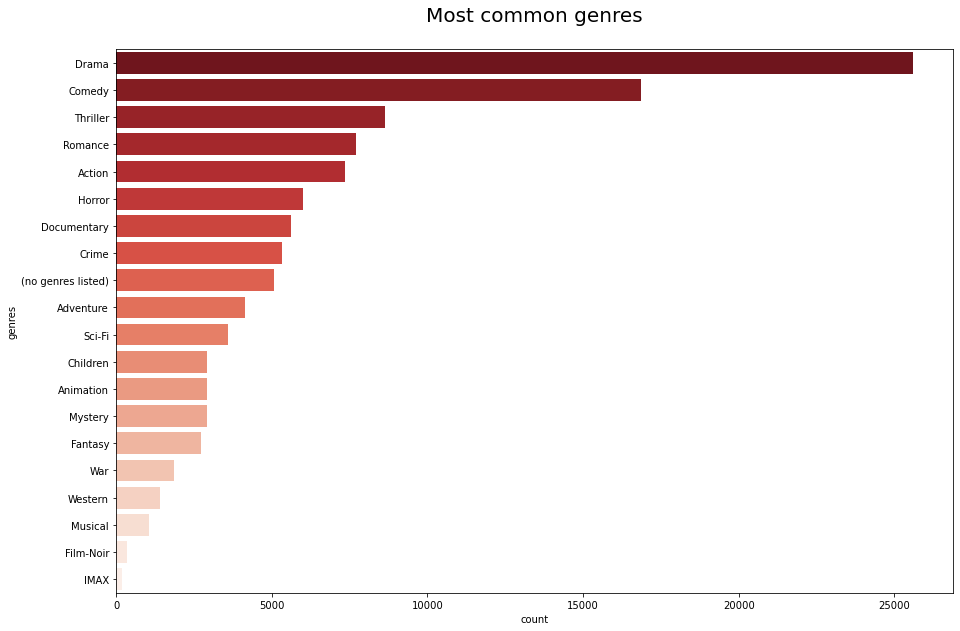

In [11]:
# Plot the genres from most common to least common
plot = plt.figure(figsize=(15, 10))
plt.title('Most common genres\n', fontsize=20)
sns.countplot(y="genres", data=movies_genres,
              order=movies_genres['genres'].value_counts(ascending=False).index,
              palette='Reds_r')
plt.show()